# BLU05 - Learning Notebook - Part 2 of 3 - SARIMAX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import utils
plt.rcParams['figure.figsize'] = (10, 4.2)

After learning the tools to understand our dataset, we start with the modelling. We'll explore the classical SARIMAX model family.

Let's get our airlines dataset. We've already become good friends after this much interaction :)

In [2]:
airlines = utils.load_airlines_series()
airlines.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: thousands of passengers, dtype: int64

In [3]:
airlines.tail()

Month
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: thousands of passengers, dtype: int64

There's one more thing we need to do before starting the modeling. Statsmodels prefers that the [index has an associated frequency](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_forecasting.html#Indexes). With this kind of index, we can refer to time periods with date strings or timestamps. Our index is a `DatetimeIndex` without a frequency.

In [4]:
airlines.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

We can add a monthly frequency like this:

In [5]:
airlines = airlines.asfreq('MS')
airlines.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Freq: MS, Name: thousands of passengers, dtype: int64

Before going into the modelling, let's make the variance of our time series approximately stationary using `log`. 

As you learned in the previous notebook, to make this time series stationary we should also `diff` it to remove the trend. Here we're going to skip that step because the model can actually do that for us.

In [6]:
airlines_logged = np.log(airlines)

Now, like in any modelling problem, let's split the dataset into _train_ and _test_ to make sure that we don't leak any information. Sometimes simply looking at the test set can give us intuition that we shouldn't have (it's like if we're studying for an exam knowing the solutions, we would be tempted to simply memorize the answers rather than actually learn). Remember that the goal of evaluating a model is to obtain a good estimation of its generalization error for never-before-seen data. For that, we need to pretend that we don't know there is a test dataset, and use it only at the end when assessing the model.

Obviously, dataset splits in time series need to take into account the temporal nature of the data. Basically, this means that in a  simple train-test split we leave the first _X_ months for training and the last _Y_ months for testing. As we're working with monthly data, let's leave 2 years (24 values) for testing:

In [7]:
train = airlines_logged.iloc[:-24]
test = airlines_logged.iloc[-24:]

In dates, this means that we have the 1949-01-01 to 1958-12-01 data in the train set and the 1959-01-01 to 1960-12-01 data in the test set.

In [8]:
train

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1958-08-01    6.224558
1958-09-01    6.001415
1958-10-01    5.883322
1958-11-01    5.736572
1958-12-01    5.820083
Freq: MS, Name: thousands of passengers, Length: 120, dtype: float64

In [9]:
test

Month
1959-01-01    5.886104
1959-02-01    5.834811
1959-03-01    6.006353
1959-04-01    5.981414
1959-05-01    6.040255
1959-06-01    6.156979
1959-07-01    6.306275
1959-08-01    6.326149
1959-09-01    6.137727
1959-10-01    6.008813
1959-11-01    5.891644
1959-12-01    6.003887
1960-01-01    6.033086
1960-02-01    5.968708
1960-03-01    6.037871
1960-04-01    6.133398
1960-05-01    6.156979
1960-06-01    6.282267
1960-07-01    6.432940
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Freq: MS, Name: thousands of passengers, dtype: float64

## 1. ARIMA 

[ARIMA](https://otexts.com/fpp3/non-seasonal-arima.html) is one of the most used models for predicting timeseries, and it stands for: 

- (AR) Auto Regressive 
- (I)  Integrated 
- (MA) Moving Average

There are also more sophisticated versions that we will get to later, but for now we'll use the plain vanilla version to develop some intuitions.

### 1.1 Hyperparameters

The ARIMA model elegantly depends only on 3 parameters: 

> `ARIMA(p,d,q)`

Looking at the meaning behind  each parameter helps us understand what this model is all about:

- `p`: the number of **A**uto-**R**egressive terms. These are the lags of the variable we want to predict. Is the present point dependent on the previous one? On the previous two? Eight? If you're curious about this, take a look at this [wiki](https://en.wikipedia.org/wiki/Autoregressive_model) and [video](https://www.youtube.com/watch?v=5-2C4eO4cPQ). An AR model can be written as $$y_t=c+\phi_1y_{t−1}+...+\phi_py_{t−p}+e_t$$ where $y_t$ is the time series at time $t$, $y_{t-1}...y_{t-p}$ are the lags of the series, $\phi_1...\phi_p$ are coefficients of the model, and $e_t$ is white noise.
- `q`: the number of **M**oving **A**verage terms. The logic here is similar to the one we used for `p`, but instead of predicting a variable based on its past values, we are predicting it based on past forecast errors. In this model, what predicts `x(t)` is `e(t-1)`, `e(t-2)`, ..., where `e(i)` is the difference between the forecasted and actual value at the ith instant. If you're curious about this, take a look at this [wiki](https://en.wikipedia.org/wiki/Moving-average_model) and [video](https://www.youtube.com/watch?v=voryLhxiPzE). An MA model can be written as $$y_t=\theta_1e_{t−1}+...+\theta_qe_{t−q}+e_t$$ where $y_t$ is the time series at time $t$, $e_{t-1}..e_{t-q}$ are past forecast errors, $\theta$ are the coefficients of the model, and $e_t$ is white noise.

- `d`: the **I**ntegrated part of the name means we take the `diff` between consecutive periods to make the timeseries stationary. You can do this in the preprocessing, but you can also leave it as a hyper parameter to tune during the model optimization. If you're curious about this, take a look at this [wiki](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) and [video](https://www.youtube.com/watch?v=3UmyHed0iYE) (suggestion: if you're going to watch the video, watch the AR and MA ones first). It means that we're going to use the differenced time series $y'$ instead of $y$.

Putting it all together we get

$$y'_t=c+\phi_1y'_{t−1}+...+\phi_py'_{t−p}+\theta_1e_{t−1}+...+\theta_qe_{t−q}+e_t$$

where $y'$ is the differenced time series.

These three hyperparameters will define the architecture of your model. The model will then be fitted to your dataset via maximum likelihood estimation. For a more thorough explanation of the math behind ARIMA, check [chapter 9](https://otexts.com/fpp3/arima.html) in the Hyndman-Athanosopoulos book or this [article](https://people.duke.edu/~rnau/411arim.htm).

In summary, the ARIMA model was created when a bunch of hungry statisticians got stuck in a cave during a massive blizzard and decided to try out boiling the AR and MA models together, while adding some Integrated seasoning in the process.

### 1.2 Hyperparameter Selection

How do we choose them? The artisanal way to decide `p` and `q` is to use the table below.

|      |         AR(p)        |         MA(q)        | ARMA(p,q) |
|:----:|:--------------------:|:--------------------:|:---------:|
|  ACF |       Tails off      | Cuts off after lag q | Tails off |
| PACF | Cuts off after lag p |       Tails off      | Tails off |

What is "cut off" and "tail off" you ask? "Cut off" means there is an abrupt decrease in ACF/PACF to 0 after a certain lag. "Tail off" means the autocorrelation is slowly decreasing over time. This [stack exchange question](https://stats.stackexchange.com/questions/241914/terms-cut-off-and-tail-off-about-acf-pacf-functions) has an interesting discussion about it.

Let's calculate the PACF and ACF plots for our train dataset. Note that we added the `.diff()` because these plots require a stationary time series. The `.dropna()` handles the `nan` value caused by the `.diff()` (the PACF and ACF functions can't handle those).

Remember that the first bar corresponds to lag 0, so it's always equal to 1.

**Side-note**: while `.dropna()` is enough to handle `nan` values right at the beginning or end of the time series (like the ones we get when using `.diff()`), you should not do this to a dataset with missing data in the middle. If you feel like a hardcore time series fan, take a look at the supplementary notebook *Handling nan in ACF like a pro* (where you can find a light explanation of this issue) after you finish the BLU.

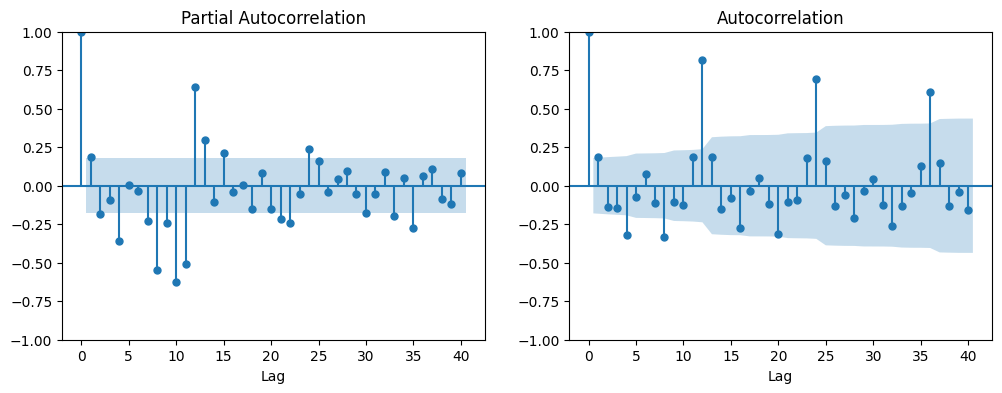

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
plot_pacf(train.diff().dropna(), alpha=.05, lags=40, ax=ax[0], method='ols') 
plot_acf(train.diff().dropna(), alpha=.05, lags=40, ax=ax[1])
ax[0].set_xlabel('Lag')
ax[1].set_xlabel('Lag');

Our case doesn't seem to be a pure _AR_ nor a pure _MA_ process because there's no clear tail off or cut off. In this situation, the autocorrelation plots can't tell us how to choose the parameters. Get used to it, because this will happen in most cases.

If you search the internet you may find several rules of thumb to try and choose the parameters in these cases, but several will be contradictory. At the end of the day the best approach is to use an automatic method, just like the hyperparameter tuning we do in machine learning models. So, let's use some parameters that have been previously found by an automatic method. Don't worry, you will learn the method in the next notebook ;)

### 1.3 Modelling

The goal of the model optimization is to achieve that the $e_t$ error term becomes white noise. This what statsmodels will do for us. If this cannot be achieved, the model does not converge and you have to choose different hyperparameters.

We will start by using our previously found parameters. Note that the `d=1` (meaning that first degree differencing is involved) may be explained by the fact that our `train` dataset isn't `diff`'ed. If we had used the diffed one (removing a possible trend in the data), we'd probably get `d=0`.

We define a variable for the parameters because we want to reuse them later. Feel free to change them if you want to play. Beware that the model will reject some combinations and others may not converge.

In [11]:
arima_order = (2, 1, 0)

We will use the [SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX) class from statsmodels to define our ARIMA model. SARIMAX is actually an extension of the ARIMA model that we'll see in the next section. The SARIMAX class from statsmodels allows us to define several model types, depending on the parameters we choose. To add to the confusion, statsmodels also has an [ARIMA](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html#statsmodels.tsa.arima.model.ARIMA) class that can be used to define a SARIMAX model. These two classes have similar capabilities and differ slightly in the formulations of the models.

In [12]:
# sets up the model using previously found parameters
arima = SARIMAX(train, order=arima_order, trend='c')

# trains the model
arima_results = arima.fit()

# calculates the in-sample prediction
# we apply the exponential to undo the log transform
arima_predictions = np.exp(arima_results.predict())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.56971D-01    |proj g|=  9.56963D-02

At iterate    5    f= -8.57038D-01    |proj g|=  4.33735D-03

At iterate   10    f= -8.57039D-01    |proj g|=  1.44485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   1.445D-04  -8.570D-01
  F = -0.85703945306338680     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [13]:
print('Can this possibly return a... %s  OH MY GOD IT DID THAT IS SO AWESOME!!' % type(arima_predictions))

Can this possibly return a... <class 'pandas.core.series.Series'>  OH MY GOD IT DID THAT IS SO AWESOME!!


A few of things to note about the API (the interface which allows us to implement the ARIMA model so easily):
1. We passed the data straight to the model (unlike in `sklearn`) .
1. We passed the order `(p, d, q)` as `(2, 1, 0)`.
1. We called `fit` without any parameters (which is also different from `sklearn`).
1. The model returns a results object [SARIMAXResults](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.html#) from which we then get the predictions.

These are our predictions. Notice that the first value is completely off because we do not have data to calculate it - the model calculates the current value from the past values in the time series.

In [14]:
arima_predictions.head()

Month
1949-01-01      1.009417
1949-02-01    113.054736
1949-03-01    120.054867
1949-04-01    135.207882
1949-05-01    126.931307
Freq: MS, Name: predicted_mean, dtype: float64

Let's plot the predictions. We leave out the non-sensical first value.

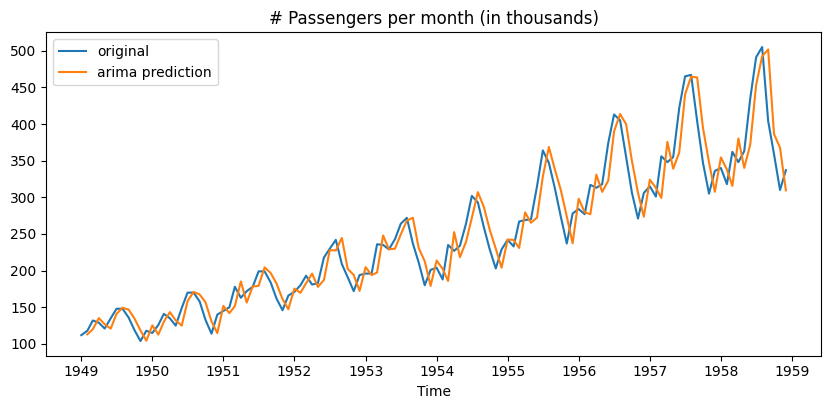

In [15]:
plt.plot(np.exp(train), label='original')
plt.plot(arima_predictions.iloc[1:], label='arima prediction')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend();

Hmm not too bad, but not perfect either. See how the forecast seems to be always late relative to the data? 

Also, there seems to be some seasonality in the data that we're not taking into account with our current model...  I guess we'll have to use the SARIMAX!

## 2. SARIMAX

This is the SARIMAX model. What does that stand for? 

<img src="https://i.imgflip.com/2ab2xu.jpg" width="500">

The **Autoregressive Integrated Moving Average** part we already know _(well... kind of anyway)_.

Now, what about the new bits?

- **`Seasonal`**: as the name suggests, this model can actually deal with seasonality. Coool.... 
- **`with eXogenous regressors`** roughly means that we can add external information to our model. For instance, if we were to predict ice cream sales, it would surely be useful to complement past sales values with the temperature time series. This will be explained in more detail in the next learning notebook.

In terms of parameters, we have  
- `p`, `d` and `q`: these are the same as before.
- `P`, `D` and `Q`: these are analogous to the previous ones, but refer to the seasonal part of the model.
- `S`: an integer giving the periodicity (number of periods in season). If we have daily data and suspect we may have weekly trends, we may want `S` to be 7. If the data is monthly and we think the time of the year may count, maybe try `S` at 12.

If you're ever curious about these parameters, look at the [documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) to understand them better. You can also look at this [section](https://otexts.com/fpp3/seasonal-arima.html) about seasonal ARIMA models.

Note on model naming: when reading about timeseries modeling, you might see names like ARMA, ARIMAX, SARIMA, ... What do they all mean? Well, depending on the parameters included in the model, you name your model. So if your model has Autoregressive and Moving Average parameters *p* and *q*, the model is called *ARMA*. If you have *p*, *d*, *q*, *exog*, the model is Autoregressive Integrated Moving Average with eXogenous regressors, so ARIMAX. The *S* in the model name means that you included the seasonal parameters *P*, *D*, *Q*. You get the idea.

Time for a break. We can imagine that by now you must feel overloaded with all these models and parameters. Keep calm! This process takes time and no one expects you to become an expert after completing this specialization. What is expected is that you get in touch with a bunch of terminology and concepts, so that you get an overall idea of time series modeling.

<img src="media/timeseries_stress.jpg" width="400">

Now, going back to time series. We just talked about a bunch of parameters... But how do we choose them? Well, `S` is quite intuitive. Looking at the ACF we can see a strong correlation with lag 12, 24, 36, etc., thus indicating yearly seasonality. Hence `S = 12`. Regarding `P`, `D` and `Q` it's even less intuitive than their lowercase cousins, so we'll just use some pre-defined values. Remember that at the end of the day we will use an automatic method to choose this, just like we do with machine learning models.

We will again use the SARIMAX class from statsmodels to define our model. This new model is actually a SARIMA because we're not using the exogenous bit (yet).

In [16]:
# sets up the SARIMA model
sarima = SARIMAX(train, trend='c',        
                         order=arima_order,            # <-- keeping same parameters as before (may not always make sense)
                         seasonal_order=(1, 1, 0, 12)) # <-- we'll get into how we found these hyperparameters later

# trains the SARIMA model
sarima_results = sarima.fit()

# predictions
# we apply the exponential to undo the log transform
sarima_predictions = np.exp(sarima_results.predict())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.61100D+00    |proj g|=  4.32830D+00


 This problem is unconstrained.



At iterate    5    f= -1.62270D+00    |proj g|=  2.00601D-02

At iterate   10    f= -1.62293D+00    |proj g|=  3.33266D-01

At iterate   15    f= -1.62322D+00    |proj g|=  5.86581D-03

At iterate   20    f= -1.62324D+00    |proj g|=  2.32607D-02

At iterate   25    f= -1.62324D+00    |proj g|=  1.40685D-02

At iterate   30    f= -1.62324D+00    |proj g|=  4.61123D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     44      1     0     0   4.611D-04  -1.623D+00
  F =  -1.6232377912671145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Done! The first value is again completely off and so is the 12th value which is affected by the seasonality parameter.

In [17]:
sarima_results.predict().head(13)

Month
1949-01-01   -0.000576
1949-02-01    4.717923
1949-03-01    4.770108
1949-04-01    4.882226
1949-05-01    4.859236
1949-06-01    4.795214
1949-07-01    4.904699
1949-08-01    4.996636
1949-09-01    4.996636
1949-10-01    4.912079
1949-11-01    4.778547
1949-12-01    4.643815
1950-01-01    7.129070
Freq: MS, Name: predicted_mean, dtype: float64

Now we can compare the ARIMA and SARIMA predictions. We're leaving out the 'bad' values.

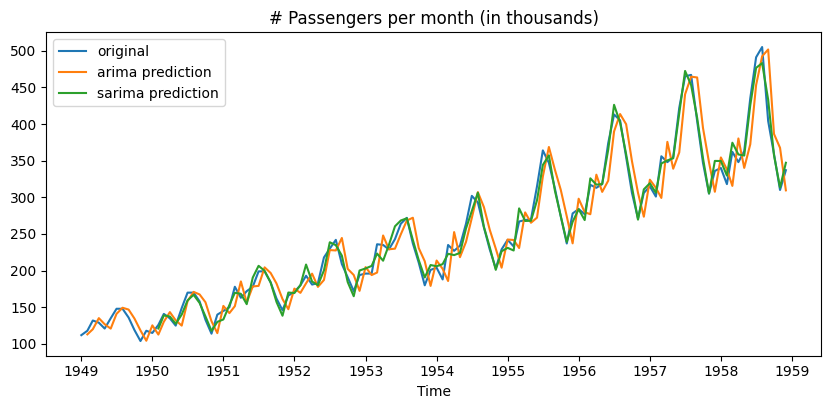

In [18]:
plt.plot(np.exp(train), label='original')
plt.plot(arima_predictions.iloc[1:], label='arima prediction')
plt.plot(sarima_predictions.iloc[13:], label='sarima prediction')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend();

From the plot, SARIMA clearly looks better, it does not lag behind thanks to the seasonality part of the model. How can we quantify this?

### 2.1 In-sample evaluation (or training performance)

The standard metric for time series classical models is the **Akaike information criterion** or **AIC**, a metric that measures how well the model fits the data while taking into account model complexity. If the model is very complex, the expectation on how well it must fit the data will also go up. It is therefore useful for comparing models.

The formula is

$$AIC \,=\,2k-2\ln({\hat {L}})$$

where $\hat {L}$ is the maximum likelihood and $k$ is the number of parameters of the model (not that you have to learn this by heart, just to help you understand what is going on). As you know from SLU09, maximum likelihood is the measure used in the optimization of the model, so it indicates how well the model fits the data. The number of parameters $k$ is included to penalize models with more parameters (remember the regularization from SLU14, lasso and ridge?).

If you (for some weird reason) feel compeled to calculate AIC by hand, [this post](https://stats.stackexchange.com/questions/87345/calculating-aic-by-hand-in-r) explains how to do so. Then again, it's sunny and beautiful outside, and statsmodels has got your back.

In [19]:
arima_results.aic

-197.68946873521284

In [20]:
sarima_results.aic

-379.5770699041076

Smaller is better, so the more negative the better. But, this metric is not appropriate to compare models with different differencing orders because it changes the data on which likelihood is computed. We can use it to choose the best p and q parameters during hyperparameter tuning, but not necessarily to compare model outcomes.

For that, it is better to use MAE or RMSE which look at the difference between the original and the predicted data. The MAE confirms the superiority of the SARIMA prediction that we saw in the plots.

In [21]:
(mean_absolute_error(arima_predictions.iloc[1:],np.exp(train[1:])),
 mean_absolute_error(sarima_predictions.iloc[13:],np.exp(train[13:])))

(21.7427140027293, 7.640920467062754)

Now you're probably thinking: we're just looking at how well each of the models fits the train dataset, not how well it generalizes. And that is correct! Let's look into doing actual forecasts with our models.

## 3. Forecasting
Previously, we used `predict()` to get **in-sample** predictions from the training subset. Now we need to use `get_forecast()` to get **out-of-sample** prediction (also called inference) from the independent test subset. Also note that in time series nomenclature, it's common to refer to in-sample predictions as **predictions** and to out-of-sample predictions as **forecasts**.

### 3.1 Individual forecasts (one-step & multi-step)
An important distinction in time series forecasting is between one-step forecasting and multi-step forecasting. **One-step** forecasting means we're just predicting the next timepoint. **Multi-step** forecasting means we're predicting multiple timepoints. The `get_forecast()` method allows us to specify how many steps we want.

In [22]:
arima_forecast = arima_results.get_forecast(24)

In [23]:
sarima_forecast = sarima_results.get_forecast(24)

Instead of specifying the steps, we can also specify the date up to which we want to forecast. This is the advantage of having a datetime index with an associated frequency. Our test set are the years 1959 and 1960, so we can say that we want the forecast up to December 1960.

In [24]:
sarima_forecast = sarima_results.get_forecast('1960-12-01')

The `get_forecast` method returns a [PredictionResults](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.mlemodel.PredictionResults.html#statsmodels.tsa.statespace.mlemodel.PredictionResults) object. To get the forecasted values, we need to use the `predicted_mean` property. And of course, apply the exponential to reverse the logging.

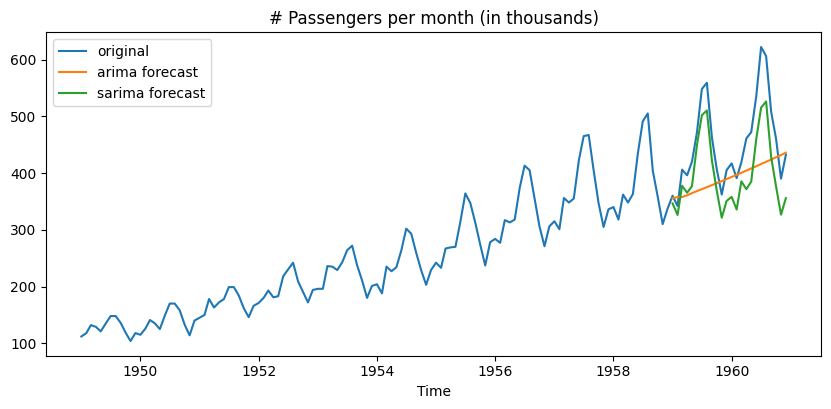

In [25]:
plt.plot(airlines, label='original')
plt.plot(np.exp(arima_forecast.predicted_mean), label='arima forecast')
plt.plot(np.exp(sarima_forecast.predicted_mean), label='sarima forecast')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend();

Great! As expected, the ARIMA forecast is just something like a trend, while the SARIMA forecast is quite good, with the seasonal peaks.

To help you understand how good is the forecast, the `PredictionResults` object offers methods and properties to calculate the confidence intervals and standard deviation. For illustration, we will obtain the confidence intervals with the `summary_frame` method and plot them below.

In [26]:
# we're applying the exponential directly here
arima_conf_int = np.exp(arima_forecast.summary_frame())
sarima_conf_int = np.exp(sarima_forecast.summary_frame())

ARIMA forecast with confidence intervals:

In [27]:
arima_conf_int.head()

thousands of passengers,mean,mean_se,mean_ci_lower,mean_ci_upper
1959-01-01,355.559848,1.107285,291.182928,434.169702
1959-02-01,357.572866,1.174174,261.030786,489.820978
1959-03-01,357.786351,1.215239,244.168748,524.272964
1959-04-01,360.709004,1.247032,234.013323,555.998197
1959-05-01,364.583595,1.276686,225.879181,588.461482


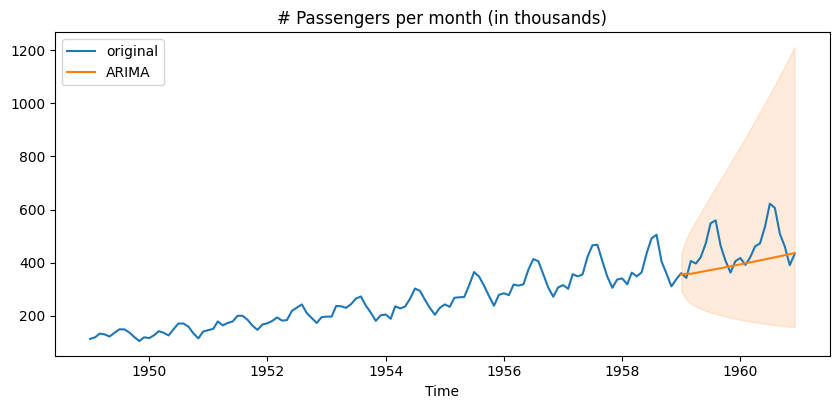

In [28]:
utils.plot_conf_int_sarimax_forecast_results(airlines, arima_conf_int, 'ARIMA')

SARIMA forecast with confidence intervals:

In [29]:
sarima_conf_int.head()

thousands of passengers,mean,mean_se,mean_ci_lower,mean_ci_upper
1959-01-01,346.509897,1.039433,321.214556,373.797221
1959-02-01,326.113080,1.046962,298.060235,356.806204
1959-03-01,377.513299,1.055442,339.626569,419.626448
1959-04-01,365.277587,1.062458,324.378963,411.332825
1959-05-01,376.952970,1.068895,330.807678,429.535198


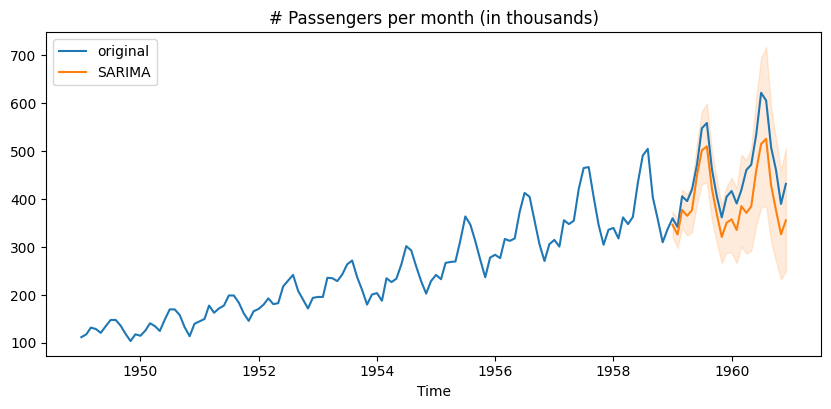

In [30]:
utils.plot_conf_int_sarimax_forecast_results(airlines, sarima_conf_int, 'SARIMA')

See how the confidence interval broadens with time? The forecast for the farther timepoints is less reliable. This brings us to the topic of the next paragraph.

### 3.2 Ongoing Forecasts

So we got our forecast and we're happy with it. But what happens as time goes by? Is our forecast still good or does it get old fast like a weather forecast?

In the real world, the processes that we are trying to forecast may evolve with time, so we usually need systems which issue forecasts regularly. In such cases we have to remind ourselves of this: as time goes on, new data becomes available. And ingesting fresh new data may be useful for model fine-tuning and grasping new dynamics in the data.

Sometimes the data really does not change and we can use models based on old data to make predictions for years to come. At other times, the change can be so extreme that we have to forget the old data and just use the most recent one. This is called data drift. In either case, you have to look at the new data, see how it behaves and possibly **retrain** our model with it.

In our example, if we need to make a forecast in `Jan 1959`, we want to use the data up to `Dec 1958`. However, to make a prediction next month, `Feb 1959`, it would be of interest to integrate the new data from the previous month into the record in an attempt to produce better forecasts.

How can we do this? There are three options:

- **Static Model:** This means that we maintain the same model, meaning the same hyperparameters (p,d,q,P,D,Q,S) and the same parameters (the ones estimated during the train set fitting). We simply add new data at the end of the original train set and change the starting point of the forecast to a later date. Remember that the model depends on the values of past timepoints, so adding new timepoints already has influence on the forecast.
- **Dynamic Model:** This means we make use of the new data to actually change our model. We can do this in two different ways:
    - **Refit:** Here we maintain the model hyperparameters, but we'll retrain the model using the new data.
    - **Remake:** Here we remake the model, meaning we will find the hyperparameters again and also retrain the model with the new data.
    
If you think about it, this is how you maintain any machine learning model. From static model, to refitting, to remaking, we're going from a more conservative to a more reactive approach to model maintenance. Being more reactive means giving more weight to new data, but also having more work because changing your model may require some validations to make sure everything's working as intended.

In practice, the path to take depends on the specifics of the project. For monthly forecasts like this, you probably don't want to maintain a static model, you can be quite confident to update it. But you probably don't want to remake the model every month.

Below, we'll show the *static* and *refit* options for the SARIMA model which we already know to be better for our data. We will do one-step forecasts for the whole test set - every month, we get the new data from the previous month and produce a forecast for the current month.

Technical note - we have to feed the new data to the model (or actually the `SARIMAXResults` object) in the same form as in the initial training of the model, in this case as a pandas series.

Here comes the *static* option. 

In [31]:
# starting with the model results we fitted previously
sarima_results_static = sarima_results

# we will store all our forecasts in this list
sarima_forecast_one_step_static = []

# for every month in the test set:
for i in np.arange(0,24):
    # make a forecast for one month
    next_step_forecast = sarima_results_static.get_forecast().predicted_mean.iloc[0]
    # store the forecast in our list
    sarima_forecast_one_step_static.append(next_step_forecast)
    # feed the observation for this month into the model for use in the next forecast
    # note the indexing with a slice to get a pandas series
    sarima_results_static = sarima_results_static.append(test.iloc[i:i+1])

This is the *refit* procedure. We will use the date indexing here to show you also this option (or maybe to confuse you more ;) ). It may take a minute or two to run. Go grab a coffee :) 

In [32]:
# starting with the model we fitted previously
sarima_results_refit = sarima_results

# we will store all our forecasts in this list
sarima_forecast_one_step_refit = []

# for every month in the test set
for i in test.index:
    # make a forecast for one month
    next_step_forecast = sarima_results_refit.get_forecast().predicted_mean.iloc[0]
    # store the forecast in our list
    sarima_forecast_one_step_refit.append(next_step_forecast)
    # feed the observation for this month into the model and refit the model
    sarima_results_refit = sarima_results_refit.append(test.loc[i:i], refit=True,
                                                         fit_kwargs={'method':'nm', 'maxiter':1000,'disp':False})

And here we plot both updated one-step forecasts together with the initial multi-step forecast:

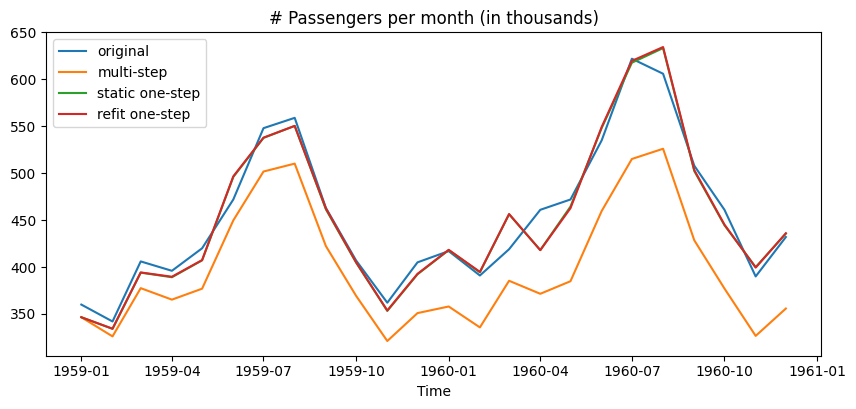

In [33]:
plt.plot(airlines.iloc[-24:], label='original') # We plot just the test data to highlight model differences
plt.plot(np.exp(sarima_forecast.predicted_mean), label='multi-step')
plt.plot(test.index,np.exp(sarima_forecast_one_step_static), label='static one-step')
plt.plot(test.index,np.exp(sarima_forecast_one_step_refit), label='refit one-step')
plt.xlabel('Time')
plt.title('# Passengers per month (in thousands)')
plt.legend();

If you can see just three curves in the plot it's because the *static* and the *refit* curves are basically the same :) Both reproduce the original test data pretty well. As expected, the *multi-step* curve is a bit worse and it is actually not really fair to compare it with the one-step forecasts. We will quantify the performance of all the forecasts in the next section.

### 3.3 Out-of-Sample Evaluation

Even though it's common to use AIC for hyperparameter optimization, the forecasts should be compared with metrics that do not depend on the model such as the mean average error (MAE) or mean squared error (MSE). These metrics are also used in cross-validation when you compare the performance of different models on the test set.

Let's calculate the MAE for our three forecasts:

In [34]:
# multi-step
mean_absolute_error(np.exp(sarima_forecast.predicted_mean),np.exp(test))

54.65735597097677

In [35]:
# static one-step
mean_absolute_error(np.exp(sarima_forecast_one_step_static),np.exp(test))

12.245188150939768

In [36]:
# refit one-step
mean_absolute_error(np.exp(sarima_forecast_one_step_refit),np.exp(test))

12.165198789788562

It's what we've already seen in the plot - the static and refit forecasts are very similar and perform better than the multi-step.

MAE gives us one number for the whole forecast, but it would be interesting to see the error for each timepoint. It is quite probable that the forecast is fine at the earliest timepoints and then progressively gets worse. We can calculate the rolling MAE with the expanding window for that.

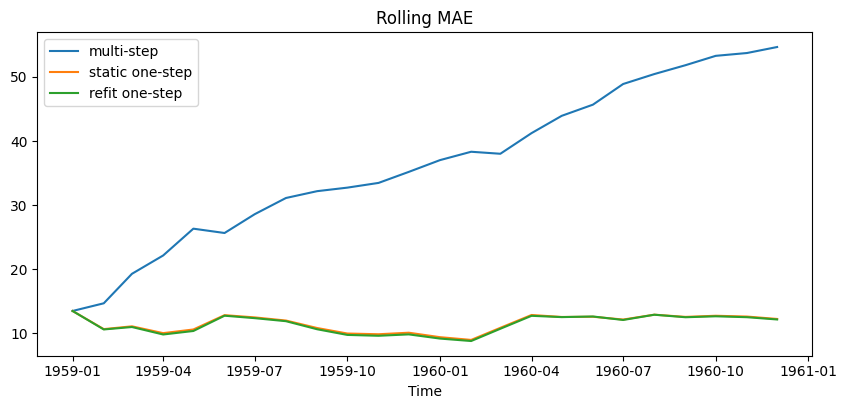

In [37]:
plt.plot(np.abs(np.exp(sarima_forecast.predicted_mean)-airlines.iloc[-24:]).expanding().mean(), label='multi-step')
plt.plot(test.index,np.abs(np.exp(sarima_forecast_one_step_static)-airlines.iloc[-24:]).expanding().mean(), label='static one-step')
plt.plot(test.index,np.abs(np.exp(sarima_forecast_one_step_refit)-airlines.iloc[-24:]).expanding().mean(), label='refit one-step')
plt.title('Rolling MAE')
plt.xlabel('Time')
plt.legend();

Well, this is interesting and it confirms what we've seen before in the confidence interval plots. The multi-step model performs progressively worse while the error of the static and refit models is relatively stable. 

This makes sense. The one-step predictions uses fresh data from the preceeding month everytime, so we kind of expect every value to be equally trustworthy as the previous one. On the othe hand, the multi-step model uses data from more and more distant past.  You can read [this section](https://otexts.com/fpp3/arima-forecasting.html) from Hyndman-Athanasopoulos to understand how multi-step forecasts are made.

## 4. Further reading
If you want to know more about statsmodels, check out the documentation [here](https://www.statsmodels.org/stable/statespace.html#) and examples [here](https://www.statsmodels.org/stable/examples/index.html#state-space-models) and [here](https://www.statsmodels.org/stable/examples/index.html#time-series-analysis). This [example](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html#Example) about model updating can be helpful.


For a difference between the ARIMA and SARIMAX formulations in statsmodels, read the [faqs](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_faq.html).

In case you're super excited about forecasting metrics (who wouldn't!), you might want to take a look at these complementary references:
- [Basics of Forecast Accuracy](https://medium.com/analytics-vidhya/basics-of-forecast-accuracy-db704b0b001b) describes the metrics commonly used in time series forecasting
- [Forecasting KPIs](https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d) explains why optimizing for RMSE makes the model aim for the mean and optimizing for MAE makes it aim for the median
- [Error Metrics: How to Evaluate Your Forecasts](https://www.jedox.com/en/blog/error-metrics-how-to-evaluate-forecasts/) describes some more metrics and their limitations.

Remember that we mentioned the choice of hyperparameters for the  SARIMAX? Proceed to the next notebook to find out more about this.